In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import scipy.constants as constant

## Old Code
Main Idea:

Monte Carlo method also random

1. In planck law, we going to choose a ranodm number that relates to the energy, with $x = E/k_b T$
2. choose random x value from 0 to 20
3. choose a random y value
4. check if the point x, y is in accordance to planck's law, with
   $$ f(x) \propto \frac{x^3}{e^x -1} $$

/tmp/ipykernel_136465/2955650445.py:22: RuntimeWarning: invalid value encountered in divide
  f = x**3 / (np.exp(x)-1)
/tmp/ipykernel_136465/2955650445.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(x, f / np.trapz(f,x), label="théorie")


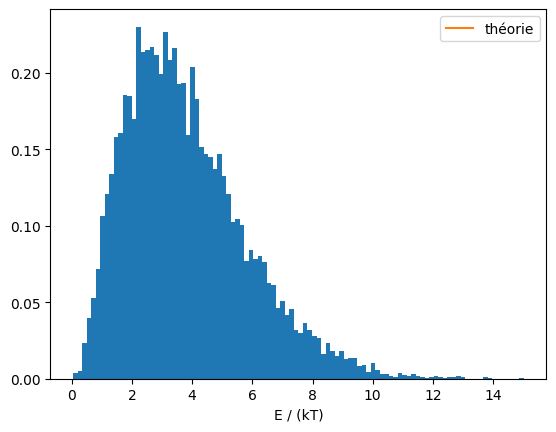

In [7]:
def sample_blackbody_E(T, N):
   k_B = 1.380649e-23  # J/K
   x_max = 20
   y_max = 2
   samples = []
   while len(samples) < N:
       x = np.random.uniform(0, x_max)
       y = np.random.uniform(0, y_max)
       f = x**3 / (np.exp(x) - 1)
       if y < f:
           samples.append(x)
   samples = np.array(samples)
   E = samples * k_B * T  # conversion en énergie
   return E

# Exemple d'utilisation :
T = 5800  # Soleil
E = sample_blackbody_E(T, N=10000)

plt.hist(E/(1.380649e-23*T), bins=100, density=True)
x = np.linspace(0,20,500)
f = x**3 / (np.exp(x)-1)
plt.plot(x, f / np.trapz(f,x), label="théorie")
#plt.plot(x, f, label="théorie")
plt.xlabel("E / (kT)")
plt.legend()
plt.show()

/tmp/ipykernel_136465/1145918148.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_norm = f / np.trapz(f, x)                     # normalize on [0, x_max]


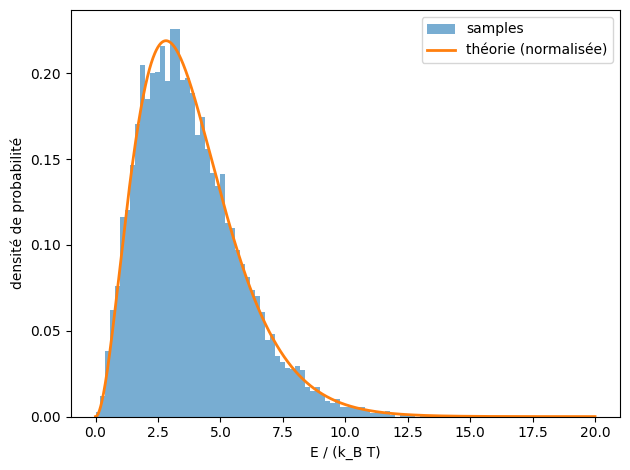

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def bb_shape(x):
    # Stable near x=0: use series x^2 when x is tiny
    x = np.asarray(x)
    out = np.empty_like(x, dtype=float)
    small = x < 1e-6
    out[small] = x[small]**2                     # limit as x->0
    out[~small] = x[~small]**3 / (np.exp(x[~small]) - 1.0)
    return out

def sample_blackbody_E(T, N, x_max=20.0, y_max=1.5):
    # simple rejection sampling; vectorized in batches for speed
    k_B = 1.380649e-23  # J/K
    samples = []
    batch = max(1000, int(N/5))
    while len(samples) < N:
        x = np.random.uniform(0.0, x_max, size=batch)
        y = np.random.uniform(0.0, y_max, size=batch)
        f = bb_shape(x)
        keep = x[y < f]
        samples.append(keep)
    x_samples = np.concatenate(samples)[:N]
    E = x_samples * k_B * T
    return E

# Example
N = 10000
T = 5800  # K (Sun)
x_max = 20.0
E = sample_blackbody_E(T, N, x_max=x_max, y_max=1.5)

# Plot in x = E/(k_B T) to compare directly with the shape function
x_samp = E / (1.380649e-23 * T)

plt.figure()
plt.hist(x_samp, bins=np.linspace(0, x_max, 101), range=(0, x_max), density=True, alpha=0.6, label="samples")

x = np.linspace(1e-6, x_max, 2000)              # avoid x=0
f = bb_shape(x)
f_norm = f / np.trapz(f, x)                     # normalize on [0, x_max]
plt.plot(x, f_norm, lw=2, label="théorie (normalisée)")

plt.xlabel("E / (k_B T)")
plt.ylabel("densité de probabilité")
plt.legend()
plt.tight_layout()
plt.show()


### In Simulation

In [18]:
class Star:
    def __init__(self, T, R, D):
        self.T = T
        self.R = R
        self.D = D
        

    def bb_shape(self, x):
    # Stable near x=0: use series x^2 when x is tiny
        x = np.asarray(x)
        out = np.empty_like(x, dtype=float)
        small = x < 1e-6
        out[small] = x[small]**2                     # limit as x->0
        out[~small] = x[~small]**3 / (np.exp(x[~small]) - 1.0)
        return out
    
    def sample_blackbody_E(self, T, N, x_max=20.0, y_max=1.5):
    # simple rejection sampling; vectorized in batches for speed
        k_B = 1.380649e-23  # J/K
        samples = []
        batch = max(1000, int(N/5))
        while len(samples) < N:
            x = np.random.uniform(0.0, x_max, size=batch)
            y = np.random.uniform(0.0, y_max, size=batch)
            f = self.bb_shape(x)
            keep = x[y < f]
            samples.append(keep)
        x_samples = np.concatenate(samples)[:N]
        E = x_samples * k_B * T
        
        return E
        
    def createPhotonPackets(self, initial, N):
        energy_samples = self.sample_blackbody_E(self.T, N)
        photons = [PhotonPacket(initial, energy_samples[i]) for i in range(N)]

        return photons

## 2nd Version

According to GPT, our model is not very correct. We apparently can double count energy/? because we are sampling photon energies by drawing a random x first, with $x = E/k_b T$. Then setting $E=xk_bT$. Then check it with 
   $$ f(x) \propto \frac{x^3}{e^x -1} $$
That weights high-energy photons twice (once in how often you sample them, and again in how much energy you give them).

That shape is the energy spectrum (per frequency). Rejection sampling accepts a proposed x with probability proportional to 
f(x). So after acceptance, the distribution of accepted x is exactly f(x). Where f(x) is bigger, you accept more often. Since 
$x^3/(e^x−1)$ puts more weight at higher x than the photon-number spectrum, you end up drawing relatively more high-energy photons.

Then you also set each packet’s energy to 
$E=xk_bT$ That means high x photons are:
- more likely to be sampled (because f is larger there), and
- carry more energy (since $E\propto x$)

Together, their contribution scales like
$$ contribution \propto f(x) \times E \times \frac{x^3}{e^x -1} \times x \propto \frac{x^4}{e^x -1} $$

which over-weights the blue compared to the true energy spectrum $\frac{x^3}{e^x -1}$

Concrete mini-example: at $x=1, f \simeq 0.58$; at $x=2, f\simeq1.25$ (≈2.15× larger). 
If you also multiply by energy (×2), the $x=2$ bin contributes $\simeq 4.3 \times$ what $x=1$ contributes - stronger bias than intended.

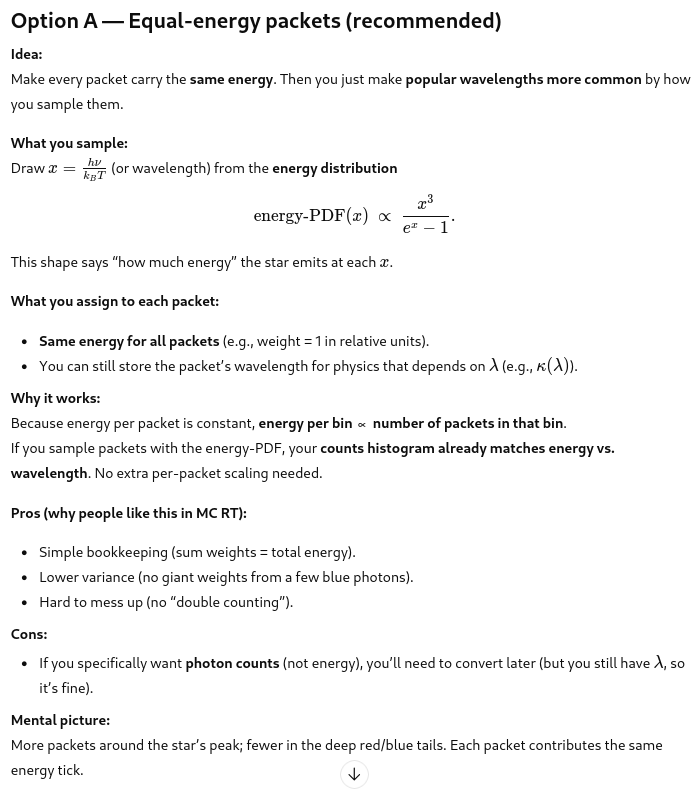
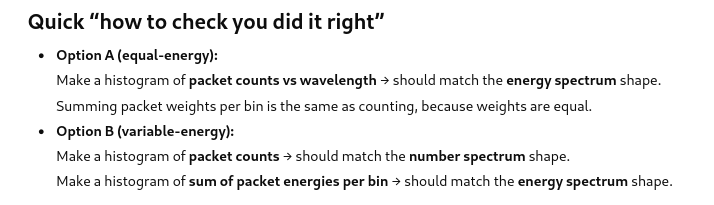

In Option A, the Planck shape comes from how often you sample each wavelength, not from per-packet energy.
So you can give every packet the same energy/weight and still match the Planck distribution, because bins with higher Planck value simply get more packets.

Quick intuition: if two wavelength bins have Planck probabilities 0.7 and 0.3, and you draw 1000 packets with equal weight w, you’ll get ~700 and ~300 packets → energies 700w and 300w. The ratio 7:3 matches the Planck curve. You do not need different weights.

#### Code fix to put in simulation)

In [19]:
def bb_shape_energy_pdf(self, x):
    x = np.asarray(x)
    out = np.empty_like(x, dtype=float)
    small = x < 1e-6
    out[small]  = x[small]**2
    out[~small] = x[~small]**3 / (np.exp(x[~small]) - 1.0)
    return out

def sample_blackbody_x(self, T, N, x_max=20.0, y_max=1.5):
    samples = []
    batch = max(1000, int(N/5))
    while len(samples) < N:
        x = np.random.uniform(0.0, x_max, size=batch)
        y = np.random.uniform(0.0, y_max, size=batch)
        f = self.bb_shape_energy_pdf(x)
        keep = x[y < f]
        samples.append(keep)
    return np.concatenate(samples)[:N]


def createPhotonPackets(self, initial, N, use_physical_units=False, area=1.0, dt=1.0):
    x_samples = self.sample_blackbody_x(self.T, N)
    # You can store wavelengths for later opacity:
    lam_samples = (h*c)/(kB*self.T*x_samples)

    if use_physical_units:
        # total band power (simplify later if you don’t have F_lambda yet)
        weight = 1.0 / N   # placeholder; replace with (band_power*area*dt)/N when you wire F_lambda
    else:
        weight = 1.0       # equal-energy packets in relative units

    photons = []
    for i in range(N):
        p = PhotonPacket(initial, weight)
        # optional: attach color for later
        p.lambda_m = lam_samples[i]
        photons.append(p)
    return photons

#### Try Code Put to The Test

/tmp/ipykernel_136465/668664771.py:76: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_m = np.trapz(F, lam_grid_m)


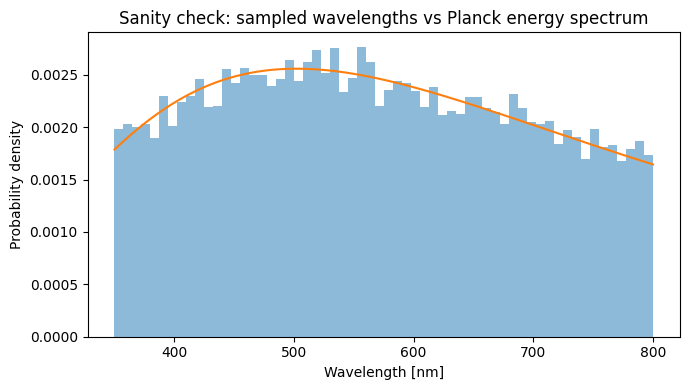

In [21]:
# Re-run the sanity check cell (single self-contained block).

import numpy as np
import matplotlib.pyplot as plt

# Physical constants (SI)
h = 6.62607015e-34       # Planck constant [J s]
c = 299792458.0          # Speed of light [m/s]
kB = 1.380649e-23        # Boltzmann constant [J/K]

# Astronomical conveniences
R_sun = 6.957e8          # Solar radius [m]
AU = 1.495978707e11      # Astronomical Unit [m]

def planck_B_lambda(lam_m, T):
    lam = np.asarray(lam_m, dtype=float)
    lam = np.clip(lam, 1e-20, None)
    a = 2.0 * h * c**2 / lam**5
    b = h * c / (lam * kB * T)
    with np.errstate(over='ignore', under='ignore'):
        return a / np.expm1(b)  # spectral radiance [W m^-2 sr^-1 m^-1]

def irradiance_F_lambda(lam_m, T, R, D):
    # F_lambda = pi * (R/D)^2 * B_lambda
    return np.pi * (R / D) ** 2 * planck_B_lambda(lam_m, T)  # [W m^-2 m^-1]

def build_cdf_from_pdf(x, pdf):
    x = np.asarray(x, dtype=float)
    pdf = np.asarray(pdf, dtype=float)
    pdf = np.clip(pdf, 0.0, None)
    dx = np.diff(x)
    mid = 0.5 * (pdf[:-1] + pdf[1:]) * dx
    cdf = np.concatenate([[0.0], np.cumsum(mid)])
    total = cdf[-1]
    if total <= 0.0:
        cdf = np.linspace(0.0, 1.0, len(x))
    else:
        cdf = cdf / total
    return x, cdf

def sample_from_cdf(cdf_x, cdf_vals, n):
    u = np.random.random(size=n)
    idx = np.searchsorted(cdf_vals, u, side='right')
    idx = np.clip(idx, 1, len(cdf_vals)-1)
    x0 = cdf_x[idx-1]; x1 = cdf_x[idx]
    y0 = cdf_vals[idx-1]; y1 = cdf_vals[idx]
    t = np.where(y1>y0, (u - y0) / (y1 - y0), 0.0)
    return x0 + t * (x1 - x0)

# Parameters
T = 5772.0
R = R_sun
D = AU
lam_min_nm, lam_max_nm = 350.0, 800.0
N = 20000  # number of equal-energy packets (relative weights)

# Build spectrum (PDF) on a wavelength grid (meters)
lam_grid_nm = np.linspace(lam_min_nm, lam_max_nm, 4096)
lam_grid_m = lam_grid_nm * 1e-9
F = irradiance_F_lambda(lam_grid_m, T, R, D)  # [W m^-2 m^-1]

# Build CDF and sample wavelengths according to energy spectrum
x, cdf = build_cdf_from_pdf(lam_grid_m, F)
lam_samples_m = sample_from_cdf(x, cdf, N)
lam_samples_nm = lam_samples_m * 1e9

# Equal-energy packets: weights are all the same (e.g., 1.0)
weights = np.ones_like(lam_samples_nm)

# Plot: histogram (density) vs normalized theoretical spectrum per-nm
plt.figure(figsize=(7,4))

bins = 60
plt.hist(lam_samples_nm, bins=bins, density=True, alpha=0.5)

area_m = np.trapz(F, lam_grid_m)
pdf_per_m = F / area_m
pdf_per_nm = pdf_per_m * 1e-9

plt.plot(lam_grid_nm, pdf_per_nm)

plt.xlabel("Wavelength [nm]")
plt.ylabel("Probability density")
plt.title("Sanity check: sampled wavelengths vs Planck energy spectrum")
plt.tight_layout()
plt.show()


/tmp/ipykernel_136465/38594954.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_norm = f / np.trapz(f, x_grid)  # normalize to integrate to 1 over [0, x_max]


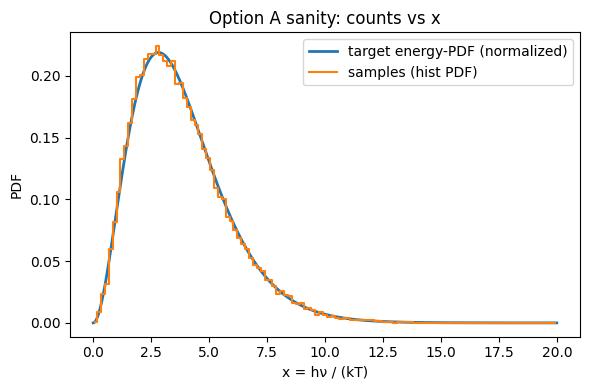

/tmp/ipykernel_136465/38594954.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B_norm = B / np.trapz(B, lam_grid)  # normalized shape over same λ-window


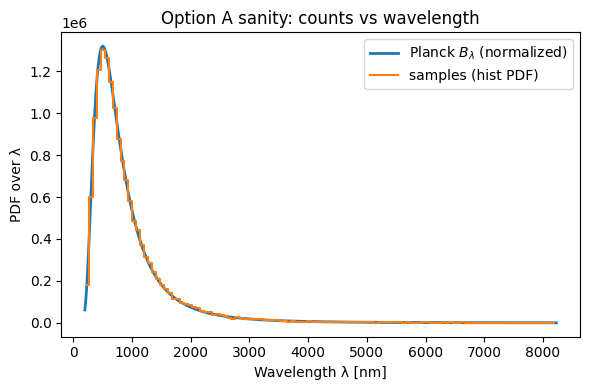

Max |sum(weights) - counts*weight| across λ-bins: 0 (should be ~0)


In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- constants ---
h  = 6.62607015e-34
c  = 2.99792458e8
kB = 1.380649e-23

# --- energy-PDF in x = hν/(kT) (∝ B_ν) ---
def bb_shape_energy_pdf(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    small = x < 1e-6
    out[small]  = x[small]**2                 # limit x→0 (series)
    out[~small] = x[~small]**3 / (np.exp(x[~small]) - 1.0)
    return out  # unnormalized shape

# --- sample x by rejection sampling (Option A) ---
def sample_blackbody_x(T, N, x_max=20.0, y_max=1.6):
    samples = []
    batch = max(1000, N//5)
    while sum(len(s) for s in samples) < N:
        x = np.random.uniform(0.0, x_max, size=batch)
        y = np.random.uniform(0.0, y_max, size=batch)
        f = bb_shape_energy_pdf(x)
        keep = x[y < f]
        samples.append(keep)
    return np.concatenate(samples)[:N]

# --- Planck in wavelength (shape only, for overlay) ---
def planck_B_lambda(lam_m, T):
    lam = np.asarray(lam_m, dtype=float)
    lam = np.clip(lam, 1e-20, None)
    a = 2*h*c**2 / lam**5
    b = h*c / (lam*kB*T)
    with np.errstate(over='ignore', under='ignore'):
        return a / (np.expm1(b))  # shape

# --- sanity check runner ---
def sanity_check_optionA(T=5800.0, N=50000, x_max=20.0):
    # 1) sample x ~ energy-PDF
    x_samp = sample_blackbody_x(T, N, x_max=x_max, y_max=1.6)

    # 2) convert to wavelength for second check: x = hc/(λ kT) -> λ = hc/(kT x)
    lam_samp = (h*c)/(kB*T*x_samp)

    # equal-energy packets → same weight for all
    weight = 1.0
    weights = np.full_like(lam_samp, weight, dtype=float)

    # ---- Check A: counts vs x match energy-PDF ----
    x_bins = np.linspace(0, x_max, 120)
    hist_x, edges_x = np.histogram(x_samp, bins=x_bins, density=True)

    x_grid = np.linspace(1e-6, x_max, 2000)
    f = bb_shape_energy_pdf(x_grid)
    f_norm = f / np.trapz(f, x_grid)  # normalize to integrate to 1 over [0, x_max]

    plt.figure(figsize=(6,4))
    centers_x = 0.5*(edges_x[1:]+edges_x[:-1])
    plt.plot(x_grid, f_norm, lw=2, label="target energy-PDF (normalized)")
    plt.plot(centers_x, hist_x, drawstyle='steps-mid', label="samples (hist PDF)")
    plt.xlabel("x = hν / (kT)")
    plt.ylabel("PDF")
    plt.title("Option A sanity: counts vs x")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- Check B: counts vs λ match B_λ shape ----
    # choose λ range from samples (trim extreme tails for nicer plot)
    lam_lo, lam_hi = np.percentile(lam_samp, [0.1, 99.9])
    lam_bins = np.linspace(lam_lo, lam_hi, 120)
    hist_lam, edges_lam = np.histogram(lam_samp, bins=lam_bins, density=True)

    lam_grid = np.linspace(lam_lo, lam_hi, 1500)
    B = planck_B_lambda(lam_grid, T)
    B_norm = B / np.trapz(B, lam_grid)  # normalized shape over same λ-window

    plt.figure(figsize=(6,4))
    centers_lam = 0.5*(edges_lam[1:]+edges_lam[:-1])
    plt.plot(lam_grid*1e9, B_norm, lw=2, label="Planck $B_\\lambda$ (normalized)")
    plt.plot(centers_lam*1e9, hist_lam, drawstyle='steps-mid', label="samples (hist PDF)")
    plt.xlabel("Wavelength λ [nm]")
    plt.ylabel("PDF over λ")
    plt.title("Option A sanity: counts vs wavelength")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- Check C: weights per bin == counts (since equal weights) ----
    counts, edges = np.histogram(lam_samp, bins=lam_bins, density=False)
    sum_w, _ = np.histogram(lam_samp, bins=lam_bins, weights=weights, density=False)
    diff = np.max(np.abs(sum_w - counts*weight))
    print(f"Max |sum(weights) - counts*weight| across λ-bins: {diff:.3g} (should be ~0)")

# run it
np.random.seed(0)
sanity_check_optionA(T=5800.0, N=40000, x_max=20.0)


### Histogram of Distribution

/tmp/ipykernel_136465/2938370598.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_norm = f / np.trapz(f, x_grid)  # normalize over [0, x_max]


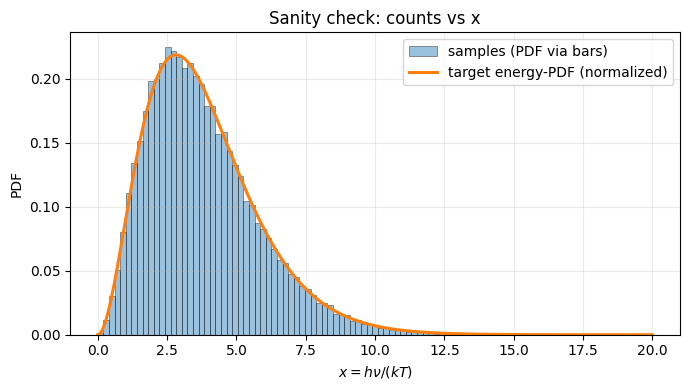

/tmp/ipykernel_136465/2938370598.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B_norm = B / np.trapz(B, lam_grid)  # normalized over same plotted window


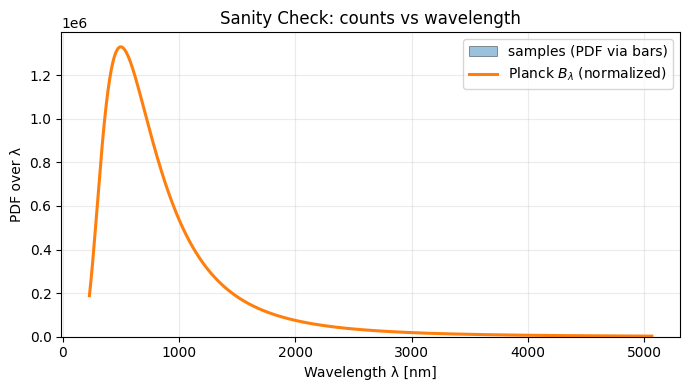

Rejection sampling acceptance rate: 20.0%
Max |sum(weights) - counts*weight| across λ-bins: 0 (should be ~0)
Approx L1 discrepancy (hist vs normalized B_lambda) over plotted window: 0.0292


/tmp/ipykernel_136465/2938370598.py:118: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Bc_norm = Bc / np.trapz(planck_B_lambda(lam_grid, T), lam_grid)
/tmp/ipykernel_136465/2938370598.py:119: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  l1_err = np.trapz(np.abs(hist_lam - Bc_norm), centers_lam)


In [30]:
# === Sanity check for Option A (equal-energy packets, sampled in x) ===
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(0)

# ---- constants (SI) ----
h  = 6.62607015e-34
c  = 2.99792458e8
kB = 1.380649e-23

# ---- energy-PDF in x = h*nu/(kT)  (shape ∝ B_nu) ----
def bb_shape_energy_pdf(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    small = x < 1e-6
    out[small]  = x[small]**2
    out[~small] = x[~small]**3 / (np.exp(x[~small]) - 1.0)
    return out  # unnormalized

# ---- sample x by rejection sampling (and report acceptance) ----
def sample_blackbody_x(T, N, x_max=20.0, y_max=1.6):
    kept = []
    total = 0
    proposed = 0
    batch = max(1000, N // 5)
    while total < N:
        x = np.random.uniform(0.0, x_max, size=batch)
        y = np.random.uniform(0.0, y_max, size=batch)
        f = bb_shape_energy_pdf(x)
        accept_mask = (y < f)
        accept = x[accept_mask]
        proposed += batch
        if accept.size:
            take = min(N - total, accept.size)
            kept.append(accept[:take])
            total += take
    x_samp = np.concatenate(kept, axis=0)
    acc_rate = len(x_samp) / proposed
    return x_samp, acc_rate

# ---- Planck in wavelength (shape only, for overlay) ----
def planck_B_lambda(lam_m, T):
    lam = np.asarray(lam_m, dtype=float)
    lam = np.clip(lam, 1e-20, None)
    a = 2*h*c**2 / lam**5
    b = h*c / (lam*kB*T)
    with np.errstate(over='ignore', under='ignore'):
        return a / (np.expm1(b))  # shape

def sanity_check_optionA(T=5800.0, N=50000, x_max=20.0, y_max=1.6):
    # 1) sample x ~ energy-PDF
    x_samp, acc_rate = sample_blackbody_x(T, N, x_max=x_max, y_max=y_max)

    # 2) convert to wavelength: x = hc/(λ kT)  ⇒  λ = hc/(kT x)
    #    (clip tiny x to avoid λ→∞ tails when plotting)
    x_samp = np.clip(x_samp, 1e-9, None)
    lam_samp = (h*c)/(kB*T*x_samp)

    # equal-energy packets → equal weights
    weight = 1.0
    weights = np.full_like(lam_samp, weight, dtype=float)

    # ---------- Plot A: counts vs x match the energy-PDF ----------
    x_bins = np.linspace(0, x_max, 100)
    hist_x, edges_x = np.histogram(x_samp, bins=x_bins, density=True)

    x_grid = np.linspace(1e-6, x_max, 2000)
    f = bb_shape_energy_pdf(x_grid)
    f_norm = f / np.trapz(f, x_grid)  # normalize over [0, x_max]

    fig, ax = plt.subplots(figsize=(7,4))
    # Visible bars: edgecolor + linewidth
    ax.hist(x_samp, bins=x_bins, density=True, alpha=0.45,
            edgecolor='k', linewidth=0.6, label="samples (PDF via bars)")
    ax.plot(x_grid, f_norm, lw=2.2, label="target energy-PDF (normalized)")
    ax.set_xlabel(r"$x = h\nu/(kT)$")
    ax.set_ylabel("PDF")
    ax.set_title("Sanity check: counts vs x")
    ax.legend()
    ax.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # ---------- Plot B: counts vs λ match normalized B_λ ----------
    # focus on central range for clarity
    lam_lo, lam_hi = np.percentile(lam_samp, [0.5, 99.5])
    lam_bins = np.linspace(lam_lo, lam_hi, 110)
    hist_lam, edges_lam = np.histogram(lam_samp, bins=lam_bins, density=True)

    lam_grid = np.linspace(lam_lo, lam_hi, 2000)
    B = planck_B_lambda(lam_grid, T)
    B_norm = B / np.trapz(B, lam_grid)  # normalized over same plotted window

    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(lam_samp*1e9, bins=(lam_bins*1e9), density=True, alpha=0.45,
            edgecolor='k', linewidth=0.6, label="samples (PDF via bars)")
    ax.plot(lam_grid*1e9, B_norm, lw=2.2, label=r"Planck $B_\lambda$ (normalized)")
    ax.set_xlabel("Wavelength λ [nm]")
    ax.set_ylabel("PDF over λ")
    ax.set_title("Sanity Check: counts vs wavelength")
    ax.legend()
    ax.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # ---------- Check C: weights per bin == counts (equal weights) ----------
    counts, _ = np.histogram(lam_samp, bins=lam_bins, density=False)
    sum_w, _ = np.histogram(lam_samp, bins=lam_bins, weights=weights, density=False)
    diff = np.max(np.abs(sum_w - counts*weight))

    # ---------- Print quick metrics ----------
    # L1-like discrepancy in the plotted λ window (hist vs curve)
    centers_lam = 0.5*(lam_bins[1:] + lam_bins[:-1])
    # approximate normalized curve at bin centers
    Bc = planck_B_lambda(centers_lam, T)
    Bc_norm = Bc / np.trapz(planck_B_lambda(lam_grid, T), lam_grid)
    l1_err = np.trapz(np.abs(hist_lam - Bc_norm), centers_lam)

    print(f"Rejection sampling acceptance rate: {acc_rate*100:.1f}%")
    print(f"Max |sum(weights) - counts*weight| across λ-bins: {diff:.3g} (should be ~0)")
    print(f"Approx L1 discrepancy (hist vs normalized B_lambda) over plotted window: {l1_err:.3g}")

# ---- run it ----
sanity_check_optionA(T=5800.0, N=40000, x_max=20.0, y_max=1.6)


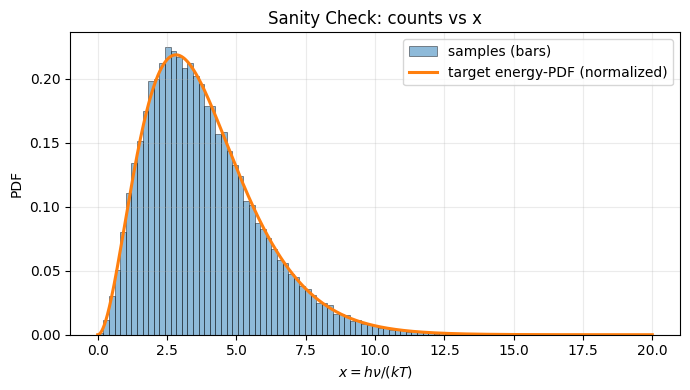

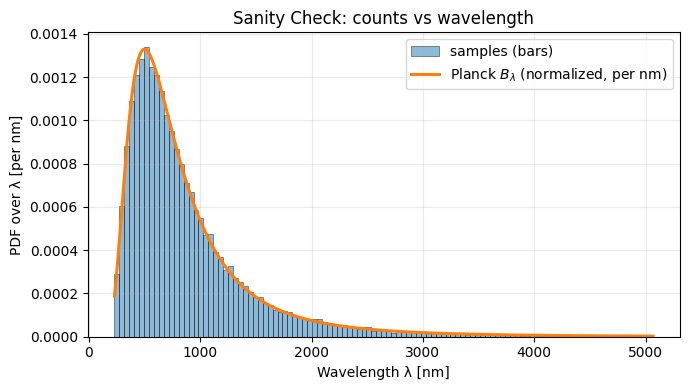

Acceptance rate: 20.0%
Max |sum(weights) - counts| across λ-bins: 0.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(0)

# ---- constants (SI) ----
h  = 6.62607015e-34
c  = 2.99792458e8
kB = 1.380649e-23

# ---- energy-PDF in x = h*nu/(kT) (shape ∝ B_nu) ----
def bb_shape_energy_pdf(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    small = x < 1e-6
    out[small]  = x[small]**2
    out[~small] = x[~small]**3 / (np.exp(x[~small]) - 1.0)
    return out  # unnormalized

# ---- sample x by rejection sampling ----
def sample_blackbody_x(T, N, x_max=20.0, y_max=1.6):
    kept = []
    total = 0
    proposed = 0
    batch = max(1000, N // 5)
    while total < N:
        x = np.random.uniform(0.0, x_max, size=batch)
        y = np.random.uniform(0.0, y_max, size=batch)
        f = bb_shape_energy_pdf(x)
        accept = x[y < f]
        proposed += batch
        if accept.size:
            take = min(N - total, accept.size)
            kept.append(accept[:take]); total += take
    return np.concatenate(kept, axis=0), (total / proposed)

# ---- Planck B_lambda (shape only) ----
def planck_B_lambda(lam_m, T):
    lam = np.asarray(lam_m, dtype=float)
    lam = np.clip(lam, 1e-20, None)
    a = 2*h*c**2 / lam**5
    b = h*c / (lam*kB*T)
    with np.errstate(over='ignore', under='ignore'):
        return a / np.expm1(b)  # [W m^-2 sr^-1 m^-1] (per meter)

def sanity_check_optionA(T=5800.0, N=40000, x_max=20.0, y_max=1.6):
    # 1) sample x ~ energy-PDF
    x_samp, acc_rate = sample_blackbody_x(T, N, x_max=x_max, y_max=y_max)
    x_samp = np.clip(x_samp, 1e-9, None)

    # 2) convert to wavelength: λ = hc/(kT x)
    lam_samp_m = (h*c) / (kB*T*x_samp)
    lam_samp_nm = lam_samp_m * 1e9

    # ---------- Plot A: counts vs x ----------
    x_bins = np.linspace(0, x_max, 100)
    x_grid = np.linspace(1e-6, x_max, 2000)
    f = bb_shape_energy_pdf(x_grid)
    f_norm = f / np.trapezoid(f, x_grid)  # normalized over [0, x_max]

    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(x_samp, bins=x_bins, density=True, alpha=0.5,
            edgecolor='k', linewidth=0.6, label="samples (bars)")
    ax.plot(x_grid, f_norm, lw=2.2, label="target energy-PDF (normalized)")
    ax.set_xlabel(r"$x = h\nu/(kT)$")
    ax.set_ylabel("PDF")
    ax.set_title("Sanity Check: counts vs x")
    ax.legend(); ax.grid(alpha=0.25)
    plt.tight_layout(); plt.show()

    # ---------- Plot B: counts vs λ (PER NM!) ----------
    # window for nicer plotting
    lam_lo_nm, lam_hi_nm = np.percentile(lam_samp_nm, [0.5, 99.5])
    lam_bins_nm = np.linspace(lam_lo_nm, lam_hi_nm, 110)
    hist_lam_nm, edges_nm = np.histogram(lam_samp_nm, bins=lam_bins_nm, density=True)

    # Build Planck curve over same window (in meters), then convert to per-nm
    lam_grid_m  = (np.linspace(lam_lo_nm, lam_hi_nm, 2000)) * 1e-9
    B_m = planck_B_lambda(lam_grid_m, T)                      # per meter
    B_m_norm = B_m / np.trapezoid(B_m, lam_grid_m)            # normalized over window (per meter)
    B_nm_norm = B_m_norm * 1e-9                               # convert to per nanometer

    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(lam_samp_nm, bins=lam_bins_nm, density=True, alpha=0.5,
            edgecolor='k', linewidth=0.6, label="samples (bars)")
    ax.plot(lam_grid_m*1e9, B_nm_norm, lw=2.2, label=r"Planck $B_\lambda$ (normalized, per nm)")
    ax.set_xlabel("Wavelength λ [nm]")
    ax.set_ylabel("PDF over λ [per nm]")
    ax.set_title("Sanity Check: counts vs wavelength")
    ax.legend(); ax.grid(alpha=0.25)
    plt.tight_layout(); plt.show()

    # ---------- Equal-weight check ----------
    counts, _ = np.histogram(lam_samp_nm, bins=lam_bins_nm, density=False)
    sum_w, _  = np.histogram(lam_samp_nm, bins=lam_bins_nm, weights=np.ones_like(lam_samp_nm), density=False)
    print(f"Acceptance rate: {acc_rate*100:.1f}%")
    print(f"Max |sum(weights) - counts| across λ-bins: {np.max(np.abs(sum_w - counts))}")

# Run
sanity_check_optionA(T=5800.0, N=40000, x_max=20.0, y_max=1.6)
